In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install japanize-matplotlib
!pip install pmdarima

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import japanize_matplotlib
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg # Import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller, pacf

## 課題1

次の手順に従って、AR(自己回帰)モデルを構築し、将来値を予測·評価しなさい。

1. ADF検定(Augmented Dickey-Fuller test)\
データの定常性を確認する。
p値に基づいて判定する(p値$<0.05$→定常、p値$≥0.05$→非定常)。

2.  PACF(偏自己相関関数)による次数(p)の選定:\
PACFグラフを描き、ARモデルの次数pを決める。
→ PACFが有意なラグで急に減衰する箇所を次数候補とする。

3. 最尤推定法(MLE)によるパラメータ推定:\
決定した次数 p を用いてARモデルをあてはめ、ARモデルの係数と誤差分散を推定する。

4. 予測と精度評価\
最後の5日間を予測し、予測値と実測値を折れ線グラフで重ねて表示する。
予測精度を MAPE(平均絶対パーセント誤差)で評価し、
予測がどの程度正確かを考察する

In [ ]:
# データ準備
df1 = pd.read_excel("/content/drive/My Drive/CIT/4S/月曜日/データサイエンス演習/授業/第6週/data_5.xlsx", sheet_name="data1")
df1['date'] = pd.to_datetime(df1['date'])
df1.set_index('date', inplace=True)

### 1. ADF 検定(Augmented Dickey-Fuller test)

In [ ]:
result = adfuller(df1['value'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] < 0.05:
    print("データは定常です（p-value < 0.05）")
else:
    print("データは非定常です（p-value >= 0.05）")


ADF Statistic: -9.354670
p-value: 0.000000
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575
データは定常です（p-value < 0.05）


### 2. PACF(偏自己相関関数)による次数(p)の選定

<Figure size 1200x600 with 0 Axes>

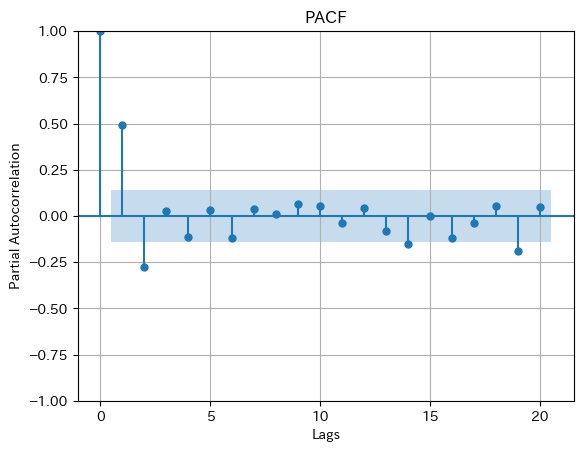

In [ ]:
plt.figure(figsize=(12, 6))
plot_pacf(df1['value'], lags=20)
plt.title('PACF')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

###3. 最尤推定法(MLE)によるパラメータ推定:

In [ ]:
# 3. 最尤推定法(MLE)によるパラメータ推定
p_order = 2
# データを訓練用とテスト用に分割する (最後の5日間をテスト用とします)
train_size = len(df1) - 5
train, test = df1[0:train_size], df1[train_size:]

# ARモデルの構築とパラメータ推定
# AutoReg モデルを使用します。lags に次数 p を指定します。
model = AutoReg(train['value'], lags=p_order)
model_fit = model.fit()

# 推定されたパラメータを表示
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  value   No. Observations:                  195
Model:                     AutoReg(2)   Log Likelihood                -281.106
Method:               Conditional MLE   S.D. of innovations              1.038
Date:                Mon, 27 Oct 2025   AIC                            570.212
Time:                        18:06:35   BIC                            583.263
Sample:                    01-03-2020   HQIC                           575.497
                         - 07-13-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0243      0.075      0.325      0.745      -0.122       0.171
value.L1       0.6239      0.069      9.024      0.000       0.488       0.759
value.L2      -0.2786      0.069     -4.030      0.0

In [ ]:
model = AutoReg(df1, lags=2).fit()
print(model.params)
sigma2 = model.sigma2
print("残差分散 =", sigma2)


const       0.003951
value.L1    0.623912
value.L2   -0.274809
dtype: float64
残差分散 = 1.1048937641641654


##4.予測と精度評価


--- 予測精度 ---
MAE  = 1.2222
MAPE = 94.07942041786264 %


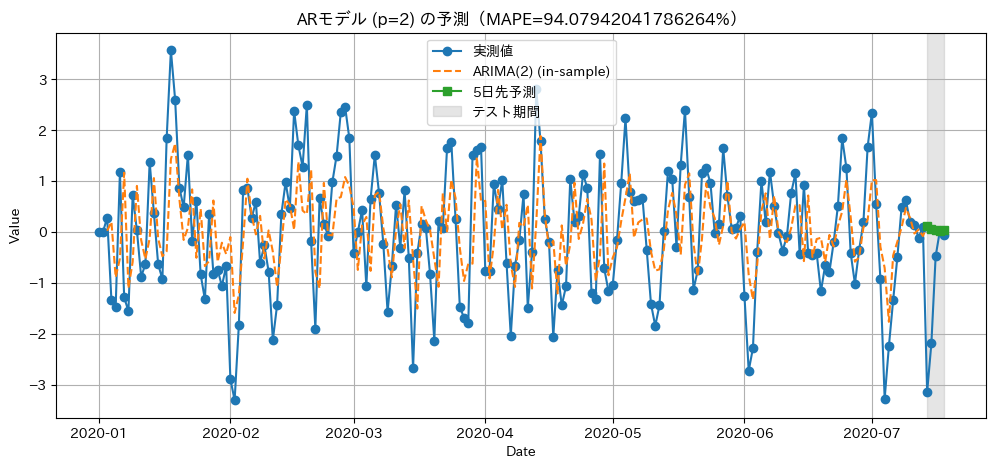

In [ ]:
TEST_HORIZON = len(test)
forecast = model_fit.forecast(steps=TEST_HORIZON)
forecast.index = test.index

mae = mean_absolute_error(test, forecast)
# MAPE計算のために0による割り算を防ぐ処理
test_values = test['value']
mask = test_values != 0
if not mask.any():
    mape = np.nan
else:
    mape = np.mean(np.abs((test_values[mask] - forecast[mask]) / test_values[mask])) * 100


print("\n--- 予測精度 ---")
print(f"MAE  = {mae:.4f}")
print(f"MAPE = {mape if not np.isnan(mape) else 'NA'} %")

pred_all = model_fit.get_prediction(start=0, end=len(df1)-1)
pred_mean = pred_all.predicted_mean
pred_mean.index = df1.index

plt.figure(figsize=(12,5))
plt.plot(df1['value'], label='実測値', marker='o')
plt.plot(pred_mean, label=f'ARIMA({p_order}) (in-sample)', linestyle='--')
plt.plot(forecast, label='5日先予測', marker='s')
plt.axvspan(test.index[0], test.index[-1], color='gray', alpha=0.2, label='テスト期間')
plt.legend()
plt.title(f'ARモデル (p={p_order}) の予測（MAPE={mape if not np.isnan(mape) else "NA"}%）')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid()
plt.show()



## 課題2

次の手順に従って、ARIMAモデルを構築し、将来値を予測·評価しなさい。

1. ADF検定(Augmented Dickey-Fuller test)\
データおよびその1次差分系列について、定常性を確認する。\
p値に基づいて定常性を判定する。\
●“p值<0.05→定常”\
●“p値≥0.05→非定常(差分が必要)”

2. 自己相関分析(ACF/PACF)\
ACF·PACFグラフを作成し、ARIMAモデルの次数(p,q)の候補を考察する、

3.  AICによるモデル選択\
AICが最小となる(p,q)を選択し、採用モデルを決定する。\
→AIC値を表にして比較してもよい。

4. 最尤推定法(MLE)によるパラメータ推定\
ARIMAモデルの係数(AR·MA)および誤差分散を推定する。

5. 予測と精度評価\
ARIMAモデルを用いて最後5日間のデータを予測し、
実際データとの誤差を計算する。\ARIMAモデルの全期間出力値と実際データをグラフ
で表示し、その間の誤差を計算する。\誤差計算はMAPE/MAE/RMSEで行う。

In [ ]:
# データ準備
df2 = pd.read_excel("/content/drive/My Drive/CIT/4S/月曜日/データサイエンス演習/授業/第6週/data_5.xlsx", sheet_name="data2")
df2['date'] = pd.to_datetime(df2['date'])
df2.set_index('date', inplace=True)

### 1. ADF 検定(Augmented Dickey-Fuller test)


In [ ]:
# 元データのADF検定
result_original = adfuller(df2['value'])
print(' 元データのADF検定結果 ')
print('ADF Statistic: %f' % result_original[0])
print('p-value: %f' % result_original[1])
print('Critical Values:')
for key, value in result_original[4].items():
    print('\t%s: %.3f' % (key, value))

if result_original[1] < 0.05:
    print("元データは定常")
else:
    print("元データは非定常")

# 1次差分系列の作成とADF検定
df2_diff1 = df2['value'].diff().dropna()
result_diff1 = adfuller(df2_diff1)

print('\n1次差分系列のADF検定結果')
print('ADF Statistic: %f' % result_diff1[0])
print('p-value: %f' % result_diff1[1])
print('Critical Values:')
for key, value in result_diff1[4].items():
    print('\t%s: %.3f' % (key, value))

if result_diff1[1] < 0.05:
    print("1次差分系列は定常")
else:
    print("1次差分系列は非定常")

 元データのADF検定結果 
ADF Statistic: -0.757960
p-value: 0.831160
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575
元データは非定常

1次差分系列のADF検定結果
ADF Statistic: -5.201621
p-value: 0.000009
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575
1次差分系列は定常


### 2.自己相関分析(ACF/PACF)

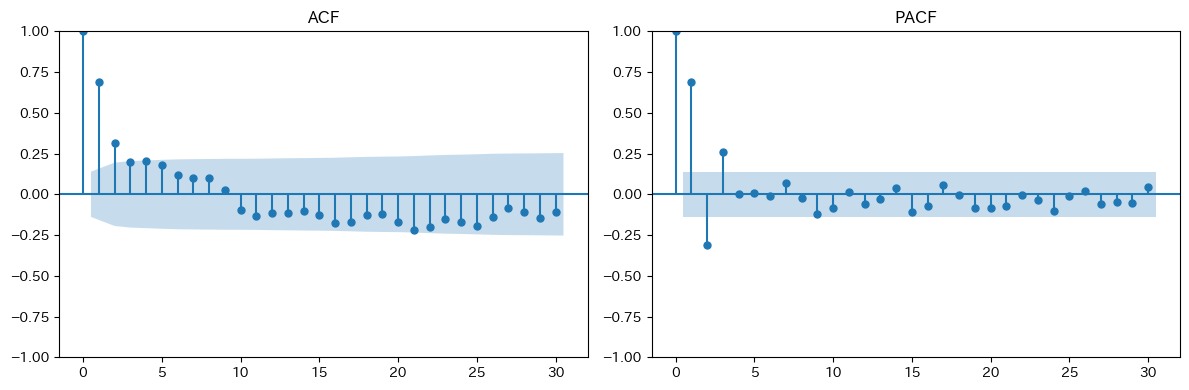

In [ ]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1)
plot_acf(df2_diff1, lags=30, ax=ax1, title="ACF")
ax2 = plt.subplot(1,2,2)
plot_pacf(df2_diff1, lags=30, ax=ax2, method='ywmle', title="PACF")
plt.tight_layout()
plt.show()

### 3.AICによるモデル選択

In [ ]:
results = []
best_aic = np.inf
best_order = None
best_model = None

# Based on ADF test results, d=1
d = 1

# データを訓練用とテスト用に分割します (最後の5日間をテスト用とします)
train_size = len(df2) - 5
train, test = df2[0:train_size], df2[train_size:]


print("\n (p,d,q) の AIC  ")
for p in range(0, 3): # Iterate through possible p values
    for q in range(0, 3): # Iterate through possible q values
        order = (p, d, q)
        try:
            # Ensure the training data is not empty
            if len(train) == 0:
                print(f"Skipping ARIMA{order}: Training data is empty.")
                continue

            m = ARIMA(train['value'], order=order)
            res = m.fit()
            aic = res.aic
            results.append((p, d, q, aic))
            print(f"ARIMA{order}  AIC = {aic:.3f}")
            if aic < best_aic:
                best_aic = aic
                best_order = order
                best_model = res
        except Exception as e:
            print(f"ARIMA{order} -> エラー: {e}")
            continue

# 表示：AIC を表に
aic_df = pd.DataFrame(results, columns=['p','d','q','AIC']).sort_values('AIC').reset_index(drop=True)
print("\n AIC 小さい順")
print(aic_df.head(10))

print(f"\n採用モデル: ARIMA{best_order} (AIC={best_aic:.3f})")


 (p,d,q) の AIC  
ARIMA(0, 1, 0)  AIC = 689.841
ARIMA(0, 1, 1)  AIC = 560.345
ARIMA(0, 1, 2)  AIC = 537.192
ARIMA(1, 1, 0)  AIC = 559.404
ARIMA(1, 1, 1)  AIC = 533.333
ARIMA(1, 1, 2)  AIC = 535.333
ARIMA(2, 1, 0)  AIC = 544.217
ARIMA(2, 1, 1)  AIC = 535.333
ARIMA(2, 1, 2)  AIC = 535.476

 AIC 小さい順
   p  d  q         AIC
0  1  1  1  533.333349
1  1  1  2  535.333313
2  2  1  1  535.333341
3  2  1  2  535.475826
4  0  1  2  537.191510
5  2  1  0  544.216900
6  1  1  0  559.404266
7  0  1  1  560.344808
8  0  1  0  689.840625

採用モデル: ARIMA(1, 1, 1) (AIC=533.333)


###4. 最尤推定法(MLE)によるパラメータ推定

In [ ]:
print("\n MLE推定結果")
print(best_model.summary())

# 係数と誤差分散（sigma2）
params = best_model.params
sigma2 = getattr(best_model, 'sigma2', None)
print("\n係数（推定値）:")
print(params)
print(f"\n誤差分散 (sigma2) = {sigma2}")



 MLE推定結果
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  195
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -263.667
Date:                Mon, 27 Oct 2025   AIC                            533.333
Time:                        18:06:42   BIC                            543.137
Sample:                    01-01-2020   HQIC                           537.303
                         - 07-13-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4751      0.089      5.368      0.000       0.302       0.649
ma.L1          0.5311      0.080      6.600      0.000       0.373       0.689
sigma2         0.8825      0.097      9.14

### 5.予測と精度評価


--- 予測精度 ---
【ARIMAモデル評価（テスト期間）】
MAE : 1.1872
RMSE: 1.2619
MAPE: 1.8044000756359875%

【ARIMAモデル評価（全期間）】
MAE (全期間): 0.7684
RMSE (全期間): 0.9480
MAPE (全期間): 10.365118782672443%


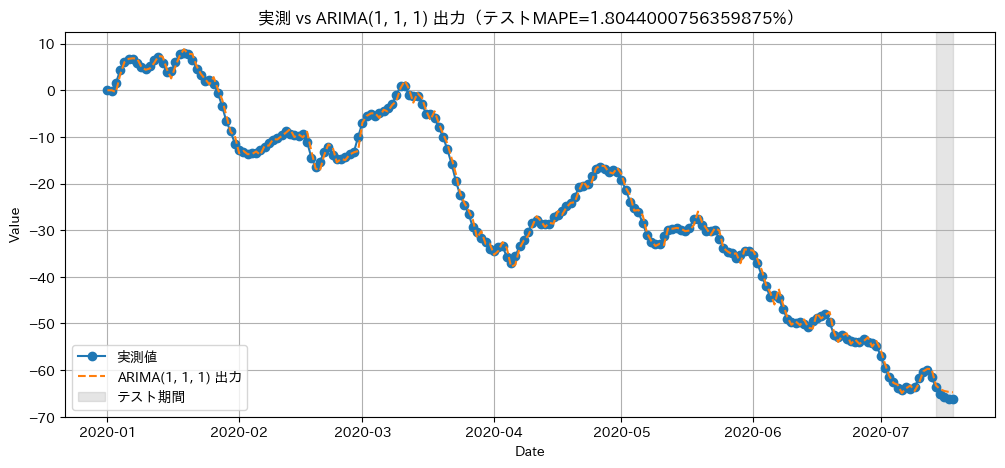


--- 最後 5 日の比較 ---
                  実測値        予測値
date                            
2020-07-14 -63.675838 -63.287311
2020-07-15 -65.215456 -64.104589
2020-07-16 -65.875639 -64.492886
2020-07-17 -66.241467 -64.677371
2020-07-18 -66.254567 -64.765021


In [ ]:
forecast = best_model.forecast(steps=TEST_HORIZON)
forecast.index = test.index

# 評価指標：MAE, RMSE, MAPE（MAPE はゼロ除外）
mae = mean_absolute_error(test['value'], forecast)
rmse = np.sqrt(mean_squared_error(test['value'], forecast))
# MAPE: ゼロを含む場合を扱う（ゼロの実測は除外して計算）
test_values = test['value']
mask = test_values != 0
if mask.sum() == 0:
    mape = np.nan
else:
    mape = np.mean(np.abs((test_values[mask] - forecast[mask]) / test_values[mask])) * 100

# 全期間のモデル出力（学習期間内の in-sample 予測を作る）
pred_all = best_model.get_prediction(start=0, end=len(df2)-1)
pred_mean = pred_all.predicted_mean
pred_mean.index = df2.index

# 全期間の評価指標（NaN を除く）
# 実測値と予測値のインデックスを揃え、NaN を含む行を削除
df2_aligned, pred_mean_aligned = df2['value'].align(pred_mean, join='inner')
combined = pd.DataFrame({'actual': df2_aligned, 'predicted': pred_mean_aligned}).dropna()

mae_all = mean_absolute_error(combined['actual'], combined['predicted'])
rmse_all = np.sqrt(mean_squared_error(combined['actual'], combined['predicted']))

# MAPE for the entire period (excluding zeros in actual values)
df2_values_aligned = combined['actual']
pred_mean_aligned = combined['predicted']
mask_all = df2_values_aligned != 0
if mask_all.sum() == 0:
  mape_all = np.nan
else:
  mape_all = np.mean(np.abs((df2_values_aligned[mask_all] - pred_mean_aligned[mask_all]) / df2_values_aligned[mask_all])) * 100


print("\n--- 予測精度 ---")
print("【ARIMAモデル評価（テスト期間）】")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape if not np.isnan(mape) else 'NA'}%")
print("\n【ARIMAモデル評価（全期間）】")
print(f"MAE (全期間): {mae_all:.4f}")
print(f"RMSE (全期間): {rmse_all:.4f}")
print(f"MAPE (全期間): {mape_all if not np.isnan(mape_all) else 'NA'}%")

# プロット：実測 vs モデル出力、テスト期間をハイライト
plt.figure(figsize=(12,5))
plt.plot(df2['value'], label='実測値', marker='o')
# NaN を除く予測値のみをプロット
plt.plot(pred_mean.dropna(), label=f'ARIMA{best_order} 出力', linestyle='--')
plt.axvspan(test.index[0], test.index[-1], color='gray', alpha=0.2, label='テスト期間')
plt.legend()
plt.title(f'実測 vs ARIMA{best_order} 出力（テストMAPE={mape if not np.isnan(mape) else "NA"}%）')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid()
plt.show()

# 最後 TEST_HORIZON 日の比較表
compare = pd.DataFrame({'実測値': test['value'], '予測値': forecast})
print("\n--- 最後 {} 日の比較 ---".format(TEST_HORIZON))
print(compare)